<br><br>

# Exercício: Sistemas de Recomendação

<br>

__Introdução: o objetivo deste exercício é discutirmos uma metodologia de avaliação de filtros colaborativos.__

<br>

Para isso, utilize a função getData() para carregar os dados: 

    - teremos avaliações que 367 usuários fizeram a respeito de 80 filmes. As notas variam entre 1, 2, 3, 4, e 5. 
    
    - os valores NaN representam filmes que ainda não foram avaliados pelos usuários.

Como __modelo__ para as recomendações, usaremos a __fatoração matricial.__ Use a classe MatrixFactorization() construída ao longo do módulo.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def getData():
    r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
    ratings = pd.read_csv('u.data', sep='\t', names=r_cols,
                          encoding='latin-1')
    m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
    movies = pd.read_csv('u.item', sep='|', names=m_cols, usecols=range(5),
                         encoding='latin-1')
    movie_ratings = pd.merge(movies, ratings)
    temp = movie_ratings[['movie_id', 'user_id', 'rating']].copy()
    temp = temp.pivot_table(columns='movie_id', index='user_id', values='rating').copy()
    temp.index = ['User_'+str(int(i)) for i in temp.index]
    temp.columns = ['Filme_'+str(int(i)) for i in temp.columns]
    qtd_cols = 80
    R = temp.iloc[:, :qtd_cols]
    l=[]
    for i in range(1, R.shape[0]+1):
        if R.iloc[i-1, ].isnull().sum() >= (qtd_cols - 10):
            l.append(i)
    R = R.drop(["User_"+str(r) for r in l])
    R.index = ['User_'+str(int(i)) for i in range(R.shape[0])]
    return R

In [3]:
import time

class MatrixFactorization():
    
    def __init__(self, dataframe, K, steps, alpha, beta):
        self.df = dataframe
        self.K = K
        self.steps = steps
        self.alpha = alpha
        self.beta = beta
        
    def fit(self):
        t0 = time.time()
        
        R = self.df.values
        N, M = R.shape
        
        #inicio aleatorio
        P = np.random.rand(N,self.K)
        Q = np.random.rand(self.K,M)
        
        lista_erro_step = []
        
        #loop
        for step in range(self.steps):
            
            mse_total_step = 0
            #varrendo todas as entradas da matriz R
            for i in range(len(R)):
                for j in range(len(R[i])):
                    #validando se o valor associado está preenchido
                    if R[i][j] > 0:

                        #calculando o erro:
                        eij = R[i][j] - np.dot(P[i,:],Q[:,j])
                        mse_total_step += (eij)**2
                        #alterando os valores
                        for k in range(self.K):
                            P[i][k] = P[i][k] + self.alpha * ( 2 * eij * Q[k][j] - self.beta * P[i][k])
                            Q[k][j] = Q[k][j] + self.alpha * ( 2 * eij * P[i][k] - self.beta * Q[k][j])
                            
            lista_erro_step.append(mse_total_step)
            
        self.P = P
        self.Q = Q
        self.lista_erro_step = lista_erro_step
        t1 = time.time()
        print("Fatoração concluída. Tempo aproximado:", int((t1-t0)/60)+1, 'minuto(s).')
        
    def predict(self):
        return self.P.dot(self.Q)
    
    def print_MSE_steps(self):
        plt.figure(figsize=[15,6])
        plt.title("Custo total por Step", fontsize = 16, fontweight = 'bold')
        plt.xlabel("Step", fontsize = 14, fontweight = 'bold')
        plt.ylabel("Erro", fontsize = 14, fontweight = 'bold')
        plt.plot(range(1, 1+self.steps), self.lista_erro_step, c = 'blue', lw = 2)
        plt.grid()
        plt.show()
        
    def mse(self):
        return min(self.lista_erro_step)

<br><br>

Tradicionalmente, para avaliarmos a performance de algoritmos de machine learning, fazemos a divisão dos dados em treino/teste; os dados de teste são utilizados no modelo final, apenas para validar que o mesmo não está sofrendo overfitting e está generalizando bem.

No contexto dos filtros colaborativos, tal divisão dos dados não fará sentido: os métodos discutidos (de filtragem colaborativa) usam as informações de interação dos usuários com itens para "preencher os valores faltantes" da matriz de interação. Esse preenchimento é justamente a recomendação!

<br>

No entanto, podemos aplicar uma __metodologia que "simula" dados de treino/teste.__ 

Essencialmente, essa metodologia consiste de criar uma base de treino em que retiramos algumas interações dos usuários. Dessa forma, os modelos irão aprender os padrões dos dados sem terem acesso a toda informação.

Nos dados de teste, usaremos essas interações retiradas em treino para avaliar os resultados.

<br>

__Considere o exemplo:__

Vamos carregar, novamente, o dataset que usamos ao longo do módulo:

In [4]:
def getDF():
    dic__ = {"User_1":[np.nan, np.nan, np.nan, 1, 7, 2, 3, 8],
         "User_2":[9,10,2,2,6,5,3,8],
         "User_3":[4, 7, 9, 6,6,10,10,2],
         "User_4":[np.nan, 7, 9, 5, 5, 10, 9, 1],
         "User_5":[7.0,6.0,3.0,8.0,3,4.0,3.0, 2],
         "User_6":[np.nan, np.nan, 9, 9,6,8,9,np.nan],
         "User_7":[3,5,4,4,3,3,9,np.nan],
         "User_8":[10,10,10,10,2,2,2,2],
         "User_9":[9,9,np.nan,8,3,3,1,np.nan],
         "User_10":[9,8,10,9,3,4,2,1],
         "User_11":[4,4,3,3,9,9,8,10],
         "User_12":[2,2,4,1,8,10,10,9],
         "User_13":[1,4,1,3,7,10,7,8],
         "User_14":[3,3,2,1,1,10, np.nan,10],
         "User_15":[9,9,8,10,4,2,np.nan,1]
        }
    df = pd.DataFrame(dic__).T
    df.columns = ['Filme_'+str(int(i+1)) for i in range(8)]
    return df

In [5]:
df = getDF()
df

,Filme_1,Filme_2,Filme_3,Filme_4,Filme_5,Filme_6,Filme_7,Filme_8
User_1,NaN,NaN,NaN,1.0,7.0,2.0,3.0,8.0
User_2,9.0,10.0,2.0,2.0,6.0,5.0,3.0,8.0
User_3,4.0,7.0,9.0,6.0,6.0,10.0,10.0,2.0
User_4,NaN,7.0,9.0,5.0,5.0,10.0,9.0,1.0
User_5,7.0,6.0,3.0,8.0,3.0,4.0,3.0,2.0
User_6,NaN,NaN,9.0,9.0,6.0,8.0,9.0,NaN
User_7,3.0,5.0,4.0,4.0,3.0,3.0,9.0,NaN
User_8,10.0,10.0,10.0,10.0,2.0,2.0,2.0,2.0
User_9,9.0,9.0,NaN,8.0,3.0,3.0,1.0,NaN
User_10,9.0,8.0,10.0,9.0,3.0,4.0,2.0,1.0


<br>

Abaixo, criamos o array "ratings", que consiste de nossa matriz de interação usuário/item. No entanto, fizemos um completamento com "0" nos dados faltantes. Dessa forma, o rating = 0 significa que o usuário não avaliou o filme em questão.

<br>

In [6]:
ratings = df.fillna(0).values
ratings

array([[ 0.,  0.,  0.,  1.,  7.,  2.,  3.,  8.],
       [ 9., 10.,  2.,  2.,  6.,  5.,  3.,  8.],
       [ 4.,  7.,  9.,  6.,  6., 10., 10.,  2.],
       [ 0.,  7.,  9.,  5.,  5., 10.,  9.,  1.],
       [ 7.,  6.,  3.,  8.,  3.,  4.,  3.,  2.],
       [ 0.,  0.,  9.,  9.,  6.,  8.,  9.,  0.],
       [ 3.,  5.,  4.,  4.,  3.,  3.,  9.,  0.],
       [10., 10., 10., 10.,  2.,  2.,  2.,  2.],
       [ 9.,  9.,  0.,  8.,  3.,  3.,  1.,  0.],
       [ 9.,  8., 10.,  9.,  3.,  4.,  2.,  1.],
       [ 4.,  4.,  3.,  3.,  9.,  9.,  8., 10.],
       [ 2.,  2.,  4.,  1.,  8., 10., 10.,  9.],
       [ 1.,  4.,  1.,  3.,  7., 10.,  7.,  8.],
       [ 3.,  3.,  2.,  1.,  1., 10.,  0., 10.],
       [ 9.,  9.,  8., 10.,  4.,  2.,  0.,  1.]])

<br>

Na sequência, apresentamos a função que faz a divisão dos dados em treino e teste.

<br>

In [7]:
def train_test_split(ratings, qtd):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=qtd, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    return train, test

In [8]:
train, test = train_test_split(ratings, qtd = 2)

<br>

__Vamos comparar os dados de treino e teste com os dados originais:__
    
<br>

In [9]:
#matriz de interação - original;

ratings

array([[ 0.,  0.,  0.,  1.,  7.,  2.,  3.,  8.],
       [ 9., 10.,  2.,  2.,  6.,  5.,  3.,  8.],
       [ 4.,  7.,  9.,  6.,  6., 10., 10.,  2.],
       [ 0.,  7.,  9.,  5.,  5., 10.,  9.,  1.],
       [ 7.,  6.,  3.,  8.,  3.,  4.,  3.,  2.],
       [ 0.,  0.,  9.,  9.,  6.,  8.,  9.,  0.],
       [ 3.,  5.,  4.,  4.,  3.,  3.,  9.,  0.],
       [10., 10., 10., 10.,  2.,  2.,  2.,  2.],
       [ 9.,  9.,  0.,  8.,  3.,  3.,  1.,  0.],
       [ 9.,  8., 10.,  9.,  3.,  4.,  2.,  1.],
       [ 4.,  4.,  3.,  3.,  9.,  9.,  8., 10.],
       [ 2.,  2.,  4.,  1.,  8., 10., 10.,  9.],
       [ 1.,  4.,  1.,  3.,  7., 10.,  7.,  8.],
       [ 3.,  3.,  2.,  1.,  1., 10.,  0., 10.],
       [ 9.,  9.,  8., 10.,  4.,  2.,  0.,  1.]])

In [10]:
#dados de treino;
#observe que, para cada usuário (ou seja, para cada linha) 3 notas foram retiradas!! 
#ou seja, foram substituida por 0.

train

array([[ 0.,  0.,  0.,  1.,  0.,  2.,  0.,  8.],
       [ 9.,  0.,  2.,  2.,  6.,  5.,  0.,  8.],
       [ 0.,  7.,  9.,  6.,  6., 10., 10.,  0.],
       [ 0.,  7.,  9.,  5.,  5.,  0.,  0.,  1.],
       [ 7.,  0.,  3.,  0.,  3.,  4.,  3.,  2.],
       [ 0.,  0.,  0.,  9.,  6.,  8.,  0.,  0.],
       [ 3.,  5.,  4.,  4.,  0.,  0.,  9.,  0.],
       [10.,  0., 10., 10.,  0.,  2.,  2.,  2.],
       [ 9.,  9.,  0.,  8.,  3.,  0.,  0.,  0.],
       [ 9.,  8., 10.,  9.,  3.,  0.,  0.,  1.],
       [ 4.,  4.,  3.,  0.,  9.,  9.,  0., 10.],
       [ 2.,  2.,  0.,  0.,  8., 10., 10.,  9.],
       [ 0.,  4.,  1.,  3.,  7., 10.,  7.,  0.],
       [ 3.,  3.,  0.,  1.,  0., 10.,  0., 10.],
       [ 9.,  9.,  0., 10.,  4.,  0.,  0.,  1.]])

In [11]:
#dados de teste;
#observe que exatamente as notas que foram retiradas de treino são colocadas nessa matriz de teste!!

test

array([[ 0.,  0.,  0.,  0.,  7.,  0.,  3.,  0.],
       [ 0., 10.,  0.,  0.,  0.,  0.,  3.,  0.],
       [ 4.,  0.,  0.,  0.,  0.,  0.,  0.,  2.],
       [ 0.,  0.,  0.,  0.,  0., 10.,  9.,  0.],
       [ 0.,  6.,  0.,  8.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  9.,  0.,  0.,  0.,  9.,  0.],
       [ 0.,  0.,  0.,  0.,  3.,  3.,  0.,  0.],
       [ 0., 10.,  0.,  0.,  2.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  3.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  4.,  2.,  0.],
       [ 0.,  0.,  0.,  3.,  0.,  0.,  8.,  0.],
       [ 0.,  0.,  4.,  1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  8.],
       [ 0.,  0.,  2.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  8.,  0.,  0.,  2.,  0.,  0.]])

<br>

Na prática, usaremos os dados de treino para treinar e escolher os modelos.

Neste caso, podemos, inclusive, fazer a divisão em treino/validação/teste:
    


In [12]:
train, val = train_test_split(train, qtd = 2)

In [13]:
train

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  8.],
       [ 9.,  0.,  2.,  2.,  0.,  0.,  0.,  8.],
       [ 0.,  0.,  9.,  6.,  0., 10., 10.,  0.],
       [ 0.,  7.,  0.,  0.,  5.,  0.,  0.,  1.],
       [ 7.,  0.,  3.,  0.,  0.,  4.,  3.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  8.,  0.,  0.],
       [ 0.,  5.,  0.,  4.,  0.,  0.,  9.,  0.],
       [ 0.,  0., 10., 10.,  0.,  2.,  0.,  2.],
       [ 0.,  0.,  0.,  8.,  3.,  0.,  0.,  0.],
       [ 0.,  0., 10.,  9.,  3.,  0.,  0.,  1.],
       [ 0.,  4.,  0.,  0.,  9.,  9.,  0., 10.],
       [ 2.,  2.,  0.,  0.,  8.,  0., 10.,  0.],
       [ 0.,  4.,  1.,  0.,  7.,  0.,  7.,  0.],
       [ 3.,  3.,  0.,  0.,  0., 10.,  0.,  0.],
       [ 0.,  9.,  0.,  0.,  4.,  0.,  0.,  1.]])

In [14]:
val

array([[ 0.,  0.,  0.,  1.,  0.,  2.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  6.,  5.,  0.,  0.],
       [ 0.,  7.,  0.,  0.,  6.,  0.,  0.,  0.],
       [ 0.,  0.,  9.,  5.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  3.,  0.,  0.,  2.],
       [ 0.,  0.,  0.,  9.,  6.,  0.,  0.,  0.],
       [ 3.,  0.,  4.,  0.,  0.,  0.,  0.,  0.],
       [10.,  0.,  0.,  0.,  0.,  0.,  2.,  0.],
       [ 9.,  9.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 9.,  8.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 4.,  0.,  3.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., 10.,  0.,  9.],
       [ 0.,  0.,  0.,  3.,  0., 10.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0., 10.],
       [ 9.,  0.,  0., 10.,  0.,  0.,  0.,  0.]])

In [15]:
test

array([[ 0.,  0.,  0.,  0.,  7.,  0.,  3.,  0.],
       [ 0., 10.,  0.,  0.,  0.,  0.,  3.,  0.],
       [ 4.,  0.,  0.,  0.,  0.,  0.,  0.,  2.],
       [ 0.,  0.,  0.,  0.,  0., 10.,  9.,  0.],
       [ 0.,  6.,  0.,  8.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  9.,  0.,  0.,  0.,  9.,  0.],
       [ 0.,  0.,  0.,  0.,  3.,  3.,  0.,  0.],
       [ 0., 10.,  0.,  0.,  2.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  3.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  4.,  2.,  0.],
       [ 0.,  0.,  0.,  3.,  0.,  0.,  8.,  0.],
       [ 0.,  0.,  4.,  1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  8.],
       [ 0.,  0.,  2.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  8.,  0.,  0.,  2.,  0.,  0.]])

<br>

Observe que, se "juntamos" os dados das 3 tabelas acima, retornamos com os dados originais:
    
<br>

In [16]:
train + val + test

array([[ 0.,  0.,  0.,  1.,  7.,  2.,  3.,  8.],
       [ 9., 10.,  2.,  2.,  6.,  5.,  3.,  8.],
       [ 4.,  7.,  9.,  6.,  6., 10., 10.,  2.],
       [ 0.,  7.,  9.,  5.,  5., 10.,  9.,  1.],
       [ 7.,  6.,  3.,  8.,  3.,  4.,  3.,  2.],
       [ 0.,  0.,  9.,  9.,  6.,  8.,  9.,  0.],
       [ 3.,  5.,  4.,  4.,  3.,  3.,  9.,  0.],
       [10., 10., 10., 10.,  2.,  2.,  2.,  2.],
       [ 9.,  9.,  0.,  8.,  3.,  3.,  1.,  0.],
       [ 9.,  8., 10.,  9.,  3.,  4.,  2.,  1.],
       [ 4.,  4.,  3.,  3.,  9.,  9.,  8., 10.],
       [ 2.,  2.,  4.,  1.,  8., 10., 10.,  9.],
       [ 1.,  4.,  1.,  3.,  7., 10.,  7.,  8.],
       [ 3.,  3.,  2.,  1.,  1., 10.,  0., 10.],
       [ 9.,  9.,  8., 10.,  4.,  2.,  0.,  1.]])

In [17]:
(train + val + test) == ratings

array([[ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True]])

<br>

Ou seja, com a metodologia acima, temos uma "divisão" dos dados em treino/validação/teste!


Desta forma, podemos usar a metologia padrão de avaliação dos modelos:
    
    - Fitamos os modelos nos dados de treino;
    
    - Avaliamos os modelos nos dados de validação;
    
    - Escolhemos o modelo final, a partir dos resultados de validação;
    
    - Avaliamos o modelo final nos dados de teste.
    
    
<br>


__Ponto de atenção:__

Ao calcularmos as métricas de performance, apenas os valores não nulos dos dados de validação/teste devem ser usados.

<br><br>

Vejamos um exemplo:

In [18]:
fat = MatrixFactorization(dataframe = pd.DataFrame(train, columns = df.columns, index = df.index), 
                          K = 5, steps = 5000, alpha = 0.0001, beta = 0.2)

In [19]:
fat.fit()

Fatoração concluída. Tempo aproximado: 1 minuto(s).


In [20]:
#predição usando apenas os dados de treino!!

pd.DataFrame(fat.predict(), columns = df.columns, index = df.index).round(2)

,Filme_1,Filme_2,Filme_3,Filme_4,Filme_5,Filme_6,Filme_7,Filme_8
User_1,6.70,3.82,3.83,3.35,7.13,8.26,8.42,7.89
User_2,8.70,2.72,2.24,1.78,5.37,7.19,5.56,7.87
User_3,6.88,5.54,8.56,6.32,5.86,9.81,9.87,6.41
User_4,1.20,6.83,4.28,4.06,4.70,3.62,7.05,1.25
User_5,6.75,1.81,2.95,2.34,2.29,3.95,3.04,4.42
User_6,5.73,3.64,4.61,3.28,5.11,7.87,7.08,6.06
User_7,2.73,4.96,4.27,4.03,6.71,6.35,8.76,4.86
User_8,3.53,4.00,9.88,9.66,3.74,2.10,8.25,1.92
User_9,3.24,3.21,8.74,7.74,3.08,3.64,7.22,2.27
User_10,2.81,4.42,9.80,8.80,2.91,2.95,7.68,1.14


<br>

Veja que a matriz resultante __não é esparsa!__

Dessa forma, como sabemos, podemos utilizá-la para as recomendações.

Como __nosso objetivo no exercício é avaliar performance__, podemos __comparar__ os resultados dessa matriz resultante com os valores dos dados de validação!

In [21]:
pd.DataFrame(val, columns = df.columns, index = df.index)

,Filme_1,Filme_2,Filme_3,Filme_4,Filme_5,Filme_6,Filme_7,Filme_8
User_1,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0
User_2,0.0,0.0,0.0,0.0,6.0,5.0,0.0,0.0
User_3,0.0,7.0,0.0,0.0,6.0,0.0,0.0,0.0
User_4,0.0,0.0,9.0,5.0,0.0,0.0,0.0,0.0
User_5,0.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0
User_6,0.0,0.0,0.0,9.0,6.0,0.0,0.0,0.0
User_7,3.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
User_8,10.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
User_9,9.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0
User_10,9.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0


<br>

### Exercício:

Carregue o conjunto de dados a partir da função getData() e utilize o modelo de fatoração matricial.

Faça uma divisão dos dados em treino/validação/teste de acordo com a metodologia acima discutida (Utilize qtd = 2, ou seja, 2 interações por usuário serão retiradas na divisão dos dados). 

Testando vários conjuntos de parâmetros - isto é, um análogo ao Grid Search de modelos - encontre a melhor fatoração matricial para realizarmos recomendações neste dataset.

Obs.: esse grid search acima pode ser feito manualmente, implementado num loop.

In [22]:
R = getData()
print(R.shape)
R

(367, 80)


,Filme_1,Filme_2,Filme_3,Filme_4,Filme_5,Filme_6,Filme_7,Filme_8,Filme_9,Filme_10,...,Filme_71,Filme_72,Filme_73,Filme_74,Filme_75,Filme_76,Filme_77,Filme_78,Filme_79,Filme_80
User_0,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,3.0,4.0,3.0,1.0,4.0,4.0,4.0,1.0,4.0,4.0
User_1,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0
User_2,4.0,NaN,NaN,NaN,NaN,NaN,2.0,4.0,4.0,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
User_3,NaN,NaN,NaN,5.0,NaN,NaN,5.0,5.0,5.0,4.0,...,5.0,5.0,3.0,NaN,NaN,NaN,5.0,3.0,4.0,4.0
User_4,4.0,NaN,NaN,4.0,NaN,NaN,4.0,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
User_362,3.0,NaN,NaN,3.0,NaN,NaN,4.0,NaN,3.0,NaN,...,NaN,3.0,4.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0
User_363,2.0,4.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
User_364,4.0,NaN,4.0,NaN,NaN,5.0,4.0,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
User_365,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Abaixo, criamos o array "ratings", que consiste de nossa matriz de interação usuário/item. No entanto, fizemos um completamento com "0" nos dados faltantes. Dessa forma, o rating = 0 significa que o usuário não avaliou o filme em questão.

In [23]:
ratings2 = R.fillna(0).values
ratings2

array([[5., 3., 4., ..., 1., 4., 4.],
       [4., 3., 0., ..., 0., 3., 2.],
       [4., 0., 0., ..., 0., 3., 0.],
       ...,
       [4., 0., 4., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 5., 2.]])

In [24]:
def train_test_split(ratings2, qtd):
    test2 = np.zeros(ratings2.shape)
    train2 = ratings2.copy()
    for user in range(ratings2.shape[0]):
        test_ratings = np.random.choice(ratings2[user, :].nonzero()[0], 
                                        size=qtd, 
                                        replace=False)
        train2[user, test_ratings] = 0.
        test2[user, test_ratings] = ratings2[user, test_ratings]
        
    return train2, test2

In [25]:
train2, test2 = train_test_split(ratings2, qtd = 2)

In [26]:
train2, val2 = train_test_split(train2, qtd = 2)

In [27]:
ratings2

array([[5., 3., 4., ..., 1., 4., 4.],
       [4., 3., 0., ..., 0., 3., 2.],
       [4., 0., 0., ..., 0., 3., 0.],
       ...,
       [4., 0., 4., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 5., 2.]])

In [28]:
train2

array([[5., 3., 4., ..., 1., 4., 4.],
       [4., 0., 0., ..., 0., 3., 2.],
       [0., 0., 0., ..., 0., 3., 0.],
       ...,
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 5., 2.]])

In [29]:
val2

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 4., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [30]:
test2

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 3., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [31]:
(train2 + val2 + test2) == ratings2

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [32]:
fat = MatrixFactorization(dataframe = R, K = 3, steps = 2000, alpha = 0.002, beta = 0.02)

In [33]:
fat.fit()

Fatoração concluída. Tempo aproximado: 8 minuto(s).


In [34]:
fat.predict()

array([[3.87452981, 3.1344084 , 3.35781175, ..., 1.6838214 , 3.99583679,
        2.72842647],
       [3.15332063, 2.44841224, 5.45723973, ..., 1.08611483, 2.97888925,
        2.43927606],
       [3.24978248, 2.61190047, 2.85919012, ..., 1.3481408 , 3.35400477,
        2.28810436],
       ...,
       [4.04339598, 3.28718359, 3.10926762, ..., 1.80343025, 4.20901352,
        2.8159597 ],
       [3.44738087, 2.89507127, 2.05760684, ..., 1.86970856, 3.61744923,
        2.37050278],
       [4.17471383, 3.4695349 , 3.24482182, ..., 2.15478747, 4.30864917,
        2.92912542]])

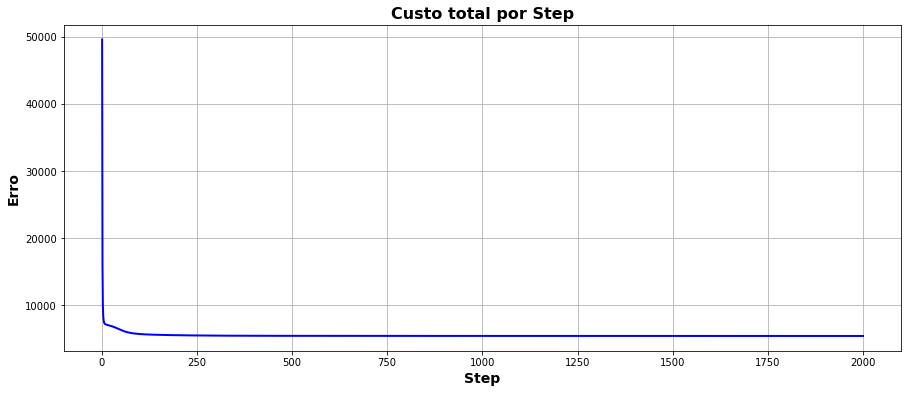

In [35]:
fat.print_MSE_steps()

In [36]:
ks=[1, 2, 3, 4, 5]
alphas=[0.000001, 0.000002, 0.000005, 0.00001, 0.0001]
betas=[0.01, 0.02, 0.05, 0.1, 1]
grid = pd.DataFrame(columns=['Ks', 'alphas', 'beta', 'MSE'])
for k in ks:
    for a in alphas:
        for b in betas:
            fat = MatrixFactorization(dataframe = pd.DataFrame(train2, columns = R.columns, index = R.index), 
                          K = k, steps = 100, alpha = a, beta = b)
            fat.fit()
            grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)

Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


Fatoração concluída. Tempo aproximado: 1 minuto(s).


C:\Users\atmal\AppData\Local\Temp\ipykernel_4656\3068559413.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid = grid.append({'Ks':k, 'alphas':a, 'beta':b, 'MSE':fat.mse()}, ignore_index=True)


In [37]:
grid

,Ks,alphas,beta,MSE
0,1.0,0.000001,0.01,93703.816056
1,1.0,0.000001,0.02,94633.513198
2,1.0,0.000001,0.05,94395.53122
3,1.0,0.000001,0.1,92587.595088
4,1.0,0.000001,1.0,94171.537952
...,...,...,...,...
120,5.0,0.0001,0.01,6090.054645
121,5.0,0.0001,0.02,6104.42278
122,5.0,0.0001,0.05,6104.737615
123,5.0,0.0001,0.1,6144.742754


In [38]:
mins = grid.min()

print("Min of Each Column:")
print(mins)

Min of Each Column:
Ks                1.0
alphas       0.000001
beta             0.01
MSE       6090.054645
dtype: object


Verificamos assim que o menor do MSE possui: k=5.0, alpha=0.0001 e beta= 0.01.